# **Retail Stock Market Behavior: Customer Segmentation and Sales Pattern Analysis**

In [1]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("meesalasreesainath/cleaned-online-retail-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.87M/5.87M [00:00<00:00, 45.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meesalasreesainath/cleaned-online-retail-dataset/versions/1


In [2]:
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        break

# Load the dataset
df = pd.read_csv(csv_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,DayOfWeek,Hour,TimeOfDay,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import re

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,DayOfWeek,Hour,TimeOfDay,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,Wednesday,8,Morning,2010-12,2010-12,1


# **RFM Calculation (From Scratch)**

Creates Recency, Frequency, Monetary for every customer

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo' : 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

print("RFM Table Ready → Shape:", rfm.shape)
rfm.head()

RFM Table Ready → Shape: (4191, 4)


,CustomerID,Recency,Frequency,Monetary
0,12347,1,7,3314.73
1,12348,248,3,90.20
2,12349,18,1,999.15
3,12350,309,1,294.40
4,12352,35,7,1130.94


# **RFM Distributions + Log Transformation**

Shows how skewed RFM is and fixes it with log1p (required before clustering).

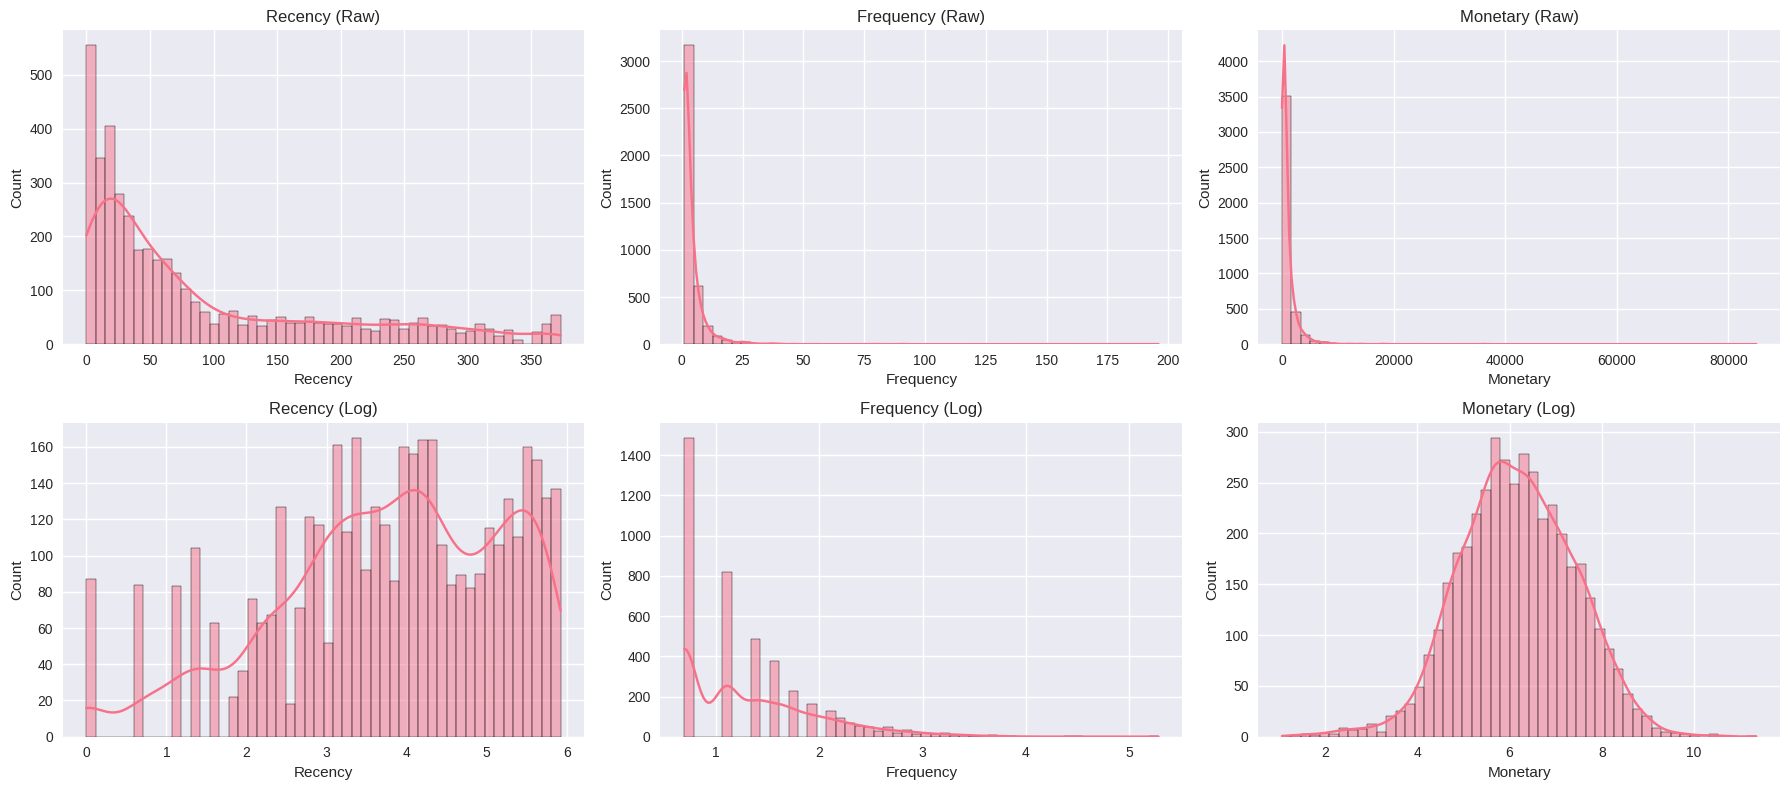

In [6]:
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

# Original
sns.histplot(rfm['Recency'], kde=True, ax=axes[0], bins=50); axes[0].set_title('Recency (Raw)')
sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], bins=50); axes[1].set_title('Frequency (Raw)')
sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], bins=50); axes[2].set_title('Monetary (Raw)')

# Log transformed
sns.histplot(rfm_log['Recency'], kde=True, ax=axes[3], bins=50); axes[3].set_title('Recency (Log)')
sns.histplot(rfm_log['Frequency'], kde=True, ax=axes[4], bins=50); axes[4].set_title('Frequency (Log)')
sns.histplot(rfm_log['Monetary'], kde=True, ax=axes[5], bins=50); axes[5].set_title('Monetary (Log)')

plt.tight_layout()
plt.show()

# **Elbow Method + Silhouette Score**

Finds optimal number of clusters

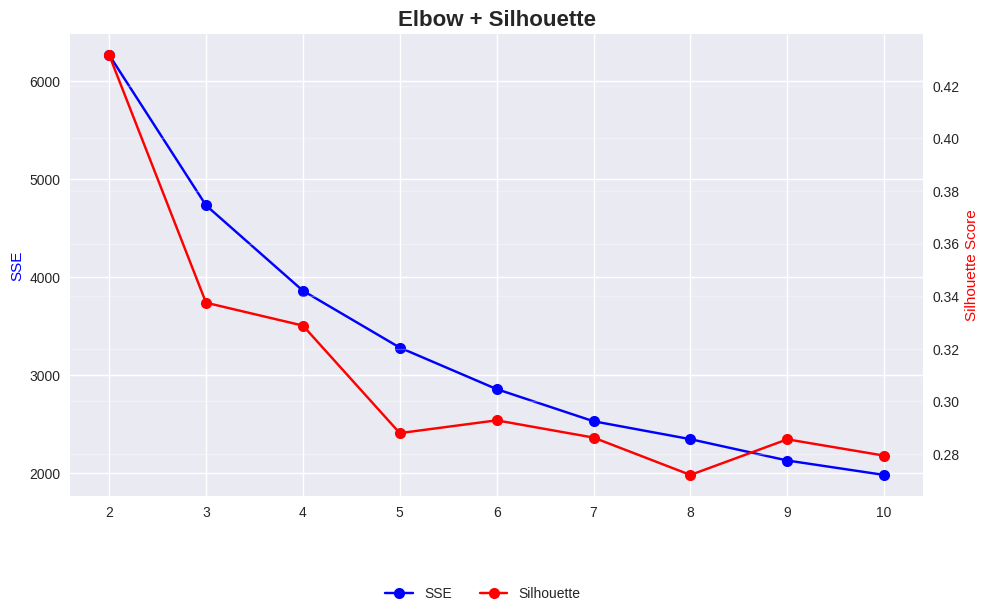

In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

sse = []
sil = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(rfm_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(11,6))
ax1.plot(K, sse, 'bo-', markersize=8, label='SSE')
ax1.set_ylabel('SSE', color='b')
ax2 = ax1.twinx()
ax2.plot(K, sil, 'ro-', markersize=8, label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('Elbow + Silhouette', fontweight='bold', fontsize=16)
plt.xlabel('Number of Clusters')
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.02), ncol=2)
plt.grid(alpha=0.3)
plt.show()

# optimal_k = 4

# **Final K-Means Clustering**

Runs final clustering and creates actionable segment names.

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

profile = rfm.groupby('Cluster').agg({
    'Recency'   : 'mean',
    'Frequency' : 'mean',
    'Monetary'  : 'mean',
    'CustomerID': 'count'
}).round(1)

profile['%'] = (profile['CustomerID'] / len(rfm) * 100).round(1)
profile = profile.sort_values('Monetary', ascending=False)

# Segment names (standard retail naming)
segment_names = {
    0: 'Champions (High Value, Recent, Frequent)',
    1: 'Loyal Customers (Frequent, Good Spenders)',
    2: 'At Risk (Spent big, but long ago)',
    3: 'Lost / Hibernating (Low everything)'
}
profile['Segment'] = profile.index.map(segment_names)

print("FINAL CUSTOMER SEGMENTS")
profile

FINAL CUSTOMER SEGMENTS


,Recency,Frequency,Monetary,CustomerID,%,Segment
Cluster,,,,,,
1,10.0,12.7,3461.4,668,15.9,"Loyal Customers (Frequent, Good Spenders)"
2,63.3,4.1,1137.7,1192,28.4,"At Risk (Spent big, but long ago)"
0,20.8,1.9,336.3,819,19.5,"Champions (High Value, Recent, Frequent)"
3,188.0,1.3,235.3,1512,36.1,Lost / Hibernating (Low everything)


# **All Cluster Visualizations**

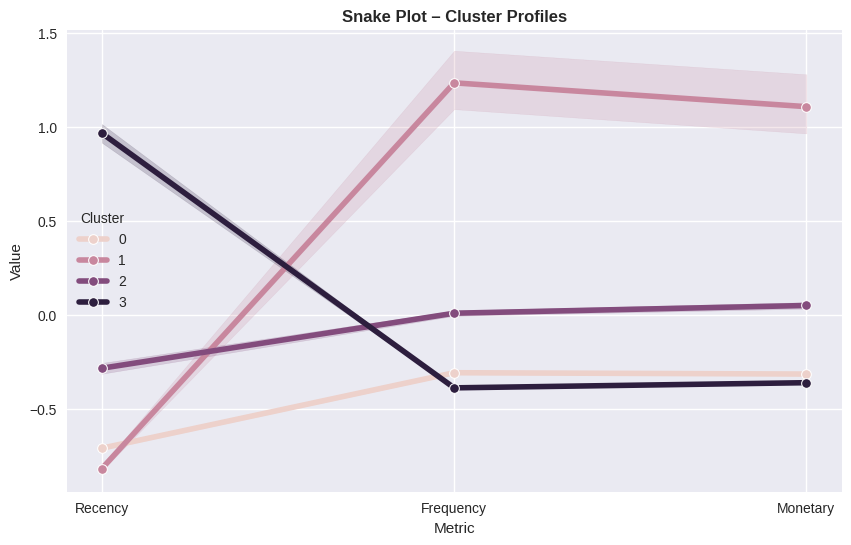

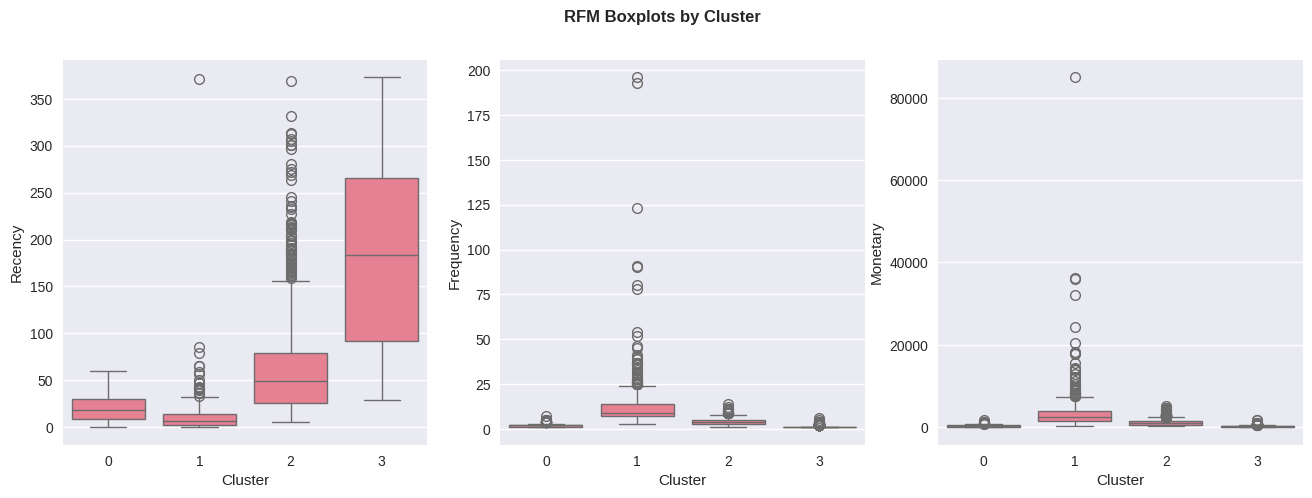

In [9]:
# 1. Snake Plot
rfm_melt = pd.melt(rfm, id_vars=['Cluster'], value_vars=['Recency','Frequency','Monetary'],
                   var_name='Metric', value_name='Value')
rfm_melt['Value'] = rfm_melt.groupby('Metric')['Value'].transform(lambda x: (x - x.mean())/x.std())

plt.figure(figsize=(10,6))
sns.lineplot(data=rfm_melt, x='Metric', y='Value', hue='Cluster', marker='o', linewidth=4)
plt.title('Snake Plot – Cluster Profiles', fontweight='bold')
plt.show()

# 2. Boxplots
fig, axes = plt.subplots(1,3, figsize=(16,5))
sns.boxplot(data=rfm, x='Cluster', y='Recency', ax=axes[0])
sns.boxplot(data=rfm, x='Cluster', y='Frequency', ax=axes[1])
sns.boxplot(data=rfm, x='Cluster', y='Monetary', ax=axes[2])
plt.suptitle('RFM Boxplots by Cluster', fontweight='bold')
plt.show()

In [10]:
# 3. 3D Interactive Plot
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary', color='Cluster',
                   size='Monetary', hover_data=['CustomerID'], title='3D RFM Clusters')
fig.show()

# **Market Basket Analysis**

Complete association rules with graphs and revenue uplift (H9 & H10)

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*utcnow.*")

# FINAL CORRECTED MARKET BASKET ANALYSIS
print("=== MARKET BASKET ANALYSIS (H9 & H10) ===\n")

# Step 1: Create clean binary basket
basket = (df[df['Country'] == 'United Kingdom']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .count().unstack().fillna(0))

# Convert to 1/0 (bought or not)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

print(f"Basket ready → {basket.shape[0]:,} transactions × {basket.shape[1]:,} items\n")

# Step 2: Apriori – use reasonable support
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Frequent itemsets found: {len(frequent_itemsets)}")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Step 3: Generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rules = rules.sort_values('lift', ascending=False).reset_index(drop=True)

print(f"\nStrong rules found: {len(rules)}")
print("TOP 15 BEST RULES (by lift):\n")
rules.iloc[:, :7].head(15)

=== MARKET BASKET ANALYSIS (H9 & H10) ===



/tmp/ipython-input-2026453607.py:13: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Basket ready → 15,144 transactions × 3,548 items



/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version.

Frequent itemsets found: 235
      support                              itemsets  length
184  0.102813  (WHITE HANGING HEART T-LIGHT HOLDER)       1
76   0.078183             (JUMBO BAG RED RETROSPOT)       1
122  0.077853                       (PARTY BUNTING)       1
12   0.071249       (ASSORTED COLOUR BIRD ORNAMENT)       1
98   0.068938             (LUNCH BAG RED RETROSPOT)       1
159  0.064778   (SET OF 3 CAKE TINS PANTRY DESIGN )       1
91   0.062797             (LUNCH BAG  BLACK SKULL.)       1
106  0.059628     (NATURAL SLATE HEART CHALKBOARD )       1
173  0.057713                      (SPOTTY BUNTING)       1
99   0.056656          (LUNCH BAG SPACEBOY DESIGN )       1

Strong rules found: 82
TOP 15 BEST RULES (by lift):



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.024234,0.039356,0.021527,0.888283,22.570744
1,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.039356,0.024234,0.021527,0.546980,22.570744
2,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.030243,0.031630,0.021527,0.711790,22.503870
3,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.031630,0.030243,0.021527,0.680585,22.503870
4,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.039356,0.031630,0.025819,0.656040,20.741281
5,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031630,0.039356,0.025819,0.816284,20.741281
6,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.025819,0.043185,0.021527,0.833760,19.306506
7,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.043185,0.025819,0.021527,0.498471,19.306506
8,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039356,0.043185,0.030243,0.768456,17.794348
9,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043185,0.039356,0.030243,0.700306,17.794348


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [12]:
# Clean table for report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*utcnow.*")

top_rules = rules.head(20).copy()
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x))[:40])
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x))[:40])

top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].round(4)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

,antecedents,consequents,support,confidence,lift
0,"PINK REGENCY TEACUP AND SAUCER, ROSES RE",GREEN REGENCY TEACUP AND SAUCER,0.0215,0.8883,22.5707
1,GREEN REGENCY TEACUP AND SAUCER,"PINK REGENCY TEACUP AND SAUCER, ROSES RE",0.0215,0.5470,22.5707
2,"GREEN REGENCY TEACUP AND SAUCER, ROSES R",PINK REGENCY TEACUP AND SAUCER,0.0215,0.7118,22.5039
3,PINK REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, ROSES R",0.0215,0.6806,22.5039
4,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.0258,0.6560,20.7413
5,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.0258,0.8163,20.7413
6,"GREEN REGENCY TEACUP AND SAUCER, PINK RE",ROSES REGENCY TEACUP AND SAUCER,0.0215,0.8338,19.3065
7,ROSES REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, PINK RE",0.0215,0.4985,19.3065
8,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.0302,0.7685,17.7943
9,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.0302,0.7003,17.7943


# **APRIORI V/S FP GROWTH**

In [13]:
import pandas as pd
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
# Show full DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
print("\n============== MBA vs FP-GROWTH COMPARISON ==============\n")
# -----------------------------------------------------------
# 1. Create the BASKET (same for both algorithms)
# -----------------------------------------------------------
basket = (df[df['Country'] == 'United Kingdom']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .count()
          .unstack()
          .fillna(0))
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
print(f"Basket Ready: {basket.shape[0]:,} transactions × {basket.shape[1]:,} products\n")


# -----------------------------------------------------------
# 2: APRIORI
# -----------------------------------------------------------
print("\n--- Running Apriori ---")
start = time.time()
apriori_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
apriori_itemsets['length'] = apriori_itemsets['itemsets'].apply(len)
end = time.time()
apriori_time = end - start
print(f"Apriori Itemsets Found: {len(apriori_itemsets)}")
print(f"Apriori Time Taken: {apriori_time:.4f} seconds")
apriori_rules = association_rules(apriori_itemsets, metric="lift", min_threshold=1.5)
apriori_rules = apriori_rules.sort_values('lift', ascending=False).reset_index(drop=True)
print(f"Apriori Rules Found: {len(apriori_rules)}")



============== MBA vs FP-GROWTH COMPARISON ==============



/tmp/ipython-input-2217353657.py:17: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Basket Ready: 15,144 transactions × 3,548 products


--- Running Apriori ---


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Apriori Itemsets Found: 235
Apriori Time Taken: 3.0763 seconds
Apriori Rules Found: 82


In [14]:
# -----------------------------------------------------------
# Step 3: FP-GROWTH
# -----------------------------------------------------------
print("\n--- Running FP-Growth ---")
start = time.time()
fpg_itemsets = fpgrowth(basket, min_support=0.02, use_colnames=True)
fpg_itemsets['length'] = fpg_itemsets['itemsets'].apply(len)
end = time.time()
fpg_time = end - start
print(f"FP-Growth Itemsets Found: {len(fpg_itemsets)}")
print(f"FP-Growth Time Taken: {fpg_time:.4f} seconds")
fpg_rules = association_rules(fpg_itemsets, metric="lift", min_threshold=1.5)
fpg_rules = fpg_rules.sort_values('lift', ascending=False).reset_index(drop=True)
print(f"FP-Growth Rules Found: {len(fpg_rules)}")


--- Running FP-Growth ---


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



FP-Growth Itemsets Found: 235
FP-Growth Time Taken: 4.5387 seconds
FP-Growth Rules Found: 82


In [15]:
# -----------------------------------------------------------
# Step 4: Show TOP 10 RULES SIDE-BY-SIDE
# -----------------------------------------------------------
print("\n============== TOP 10 RULES (Apriori) ==============\n")
print(apriori_rules.iloc[:, :7].head(10).to_string())
print("\n============== TOP 10 RULES (FP-Growth) ==============\n")
print(fpg_rules.iloc[:, :7].head(10).to_string())
# -----------------------------------------------------------
# Step 5: SUMMARY COMPARISON
# -----------------------------------------------------------
print("\n=================== PRACTICAL COMPARISON ===================")
print(f"""
Algorithm        Itemsets Found     Rules Found     Time Taken (sec)
---------------------------------------------------------------------
Apriori              {len(apriori_itemsets):<18} {len(apriori_rules):<15} {apriori_time:.4f}
FP-Growth            {len(fpg_itemsets):<18} {len(fpg_rules):<15} {fpg_time:.4f}
""")


============== TOP 10 RULES (Apriori) ==============

                                                           antecedents                                                          consequents  antecedent support  consequent support   support  confidence       lift
0   (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )                                    (GREEN REGENCY TEACUP AND SAUCER)            0.024234            0.039356  0.021527    0.888283  22.570744
1                                    (GREEN REGENCY TEACUP AND SAUCER)   (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )            0.039356            0.024234  0.021527    0.546980  22.570744
2  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER )                                     (PINK REGENCY TEACUP AND SAUCER)            0.030243            0.031630  0.021527    0.711790  22.503870
3                                     (PINK REGENCY TEACUP AND SAUCER)  (GREEN REGENCY TEACUP

# **PREDICTIVE ANALYSIS**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*utcnow.*")

**Predict Big Orders (> £500) – XGBoost Classifier**

H2 – Big Order Prediction
Accuracy : 0.969
F1-Score : 0.844


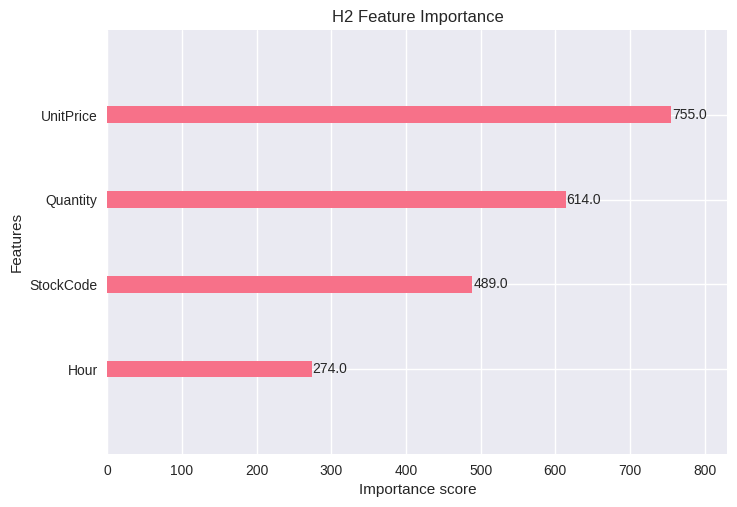

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*utcnow.*")

order_df = df.groupby('InvoiceNo').agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'StockCode': 'nunique',
    'Hour': 'first',
    'DayOfWeek': 'first'
}).reset_index()

order_df['BigOrder'] = (order_df['TotalPrice'] > 500).astype(int)

X = order_df[['Quantity', 'UnitPrice', 'StockCode', 'Hour']]
y = order_df['BigOrder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_h2 = xgb.XGBClassifier(random_state=42)
model_h2.fit(X_train, y_train)
pred = model_h2.predict(X_test)

print("H2 – Big Order Prediction")
print(f"Accuracy : {accuracy_score(y_test, pred):.3f}")
print(f"F1-Score : {f1_score(y_test, pred):.3f}")
xgb.plot_importance(model_h2)
plt.title('H2 Feature Importance')
plt.show()

H2 – Big Order Prediction (Random Forest)
Accuracy : 0.972
F1-Score : 0.863


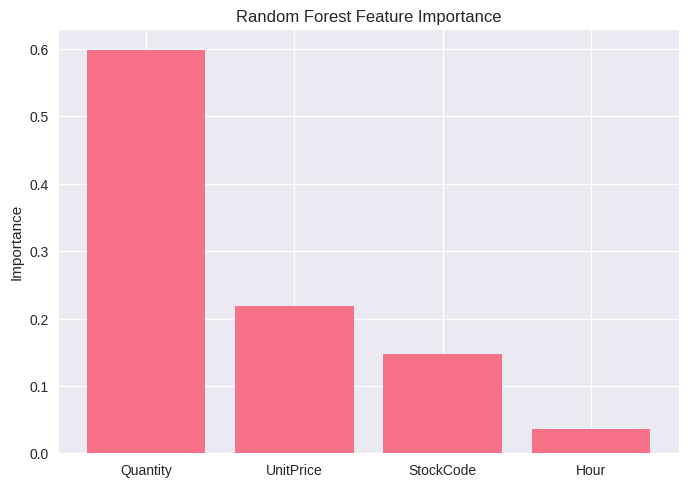

In [18]:
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# Random Forest Model (H2)
# -----------------------------
model_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

print("H2 – Big Order Prediction (Random Forest)")
print(f"Accuracy : {accuracy_score(y_test, pred_rf):.3f}")
print(f"F1-Score : {f1_score(y_test, pred_rf):.3f}")

# Feature importance plot
importances = model_rf.feature_importances_
plt.bar(X.columns, importances)
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()
